# 2019  + 2024 Contrail ERF Proportions

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import LogNorm

import numpy as np

In [2]:
# 2019: download https://storage.googleapis.com/contrails-301217-public-data/2019-erf.orig.nc
# 2024: download https://storage.googleapis.com/contrails-301217-public-data/2014-erf.orig.nc

In [11]:
year = 2019

In [12]:
ds = xr.open_dataset(f"{year}-erf.orig.nc").rename({"ef_net_overlap": "erf_percent"})

In [13]:
# ds["erf_percent"].plot(x="longitude", y="latitude", cmap="Reds");

In [14]:
ds["erf_percent"].T.to_netcdf(f"{year}.nc", 
             format="NETCDF3_CLASSIC", 
             engine="netcdf4",
            )

## Image

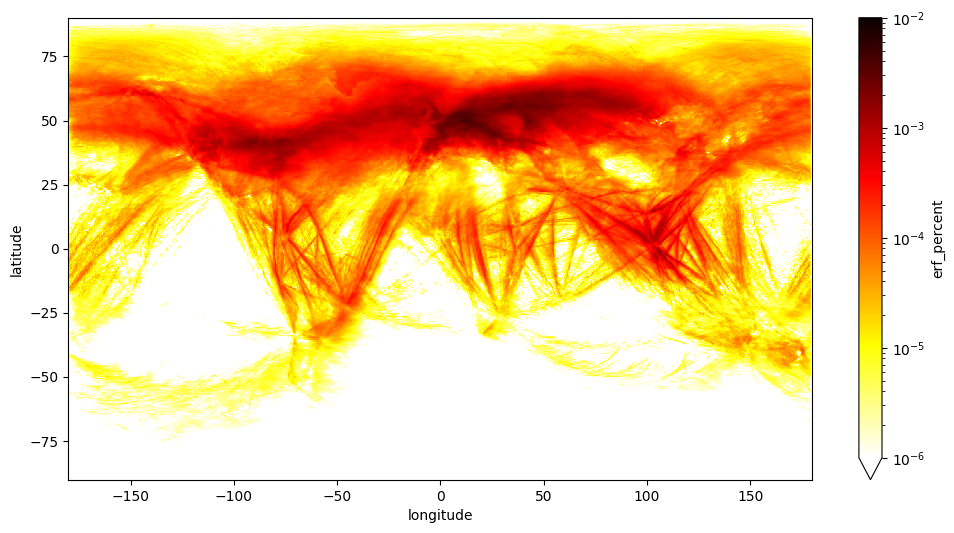

In [15]:
# test
da = ds["erf_percent"]
min_val = 1e-6 # da.min()
max_val = 1e-2 # da.max()
cmap = "hot_r"
da.plot.imshow(x="longitude", y="latitude", cmap=cmap, norm=LogNorm(vmin=min_val, vmax=max_val), figsize=(12,6))

In [16]:
!rm {year}.png

# transpose dims
da = ds["erf_percent"].T

# reverse latitude
da = da.isel(latitude=slice(None, None, -1))

min_val = 1e-6 # da.min()
max_val = 1e-2 # da.max()

# clip and fill with nan
# da = xr.where(da < min_val, 0, da)
# da = xr.where(da > max_val, max_val, da)

# Get bounds
lon_min, lon_max = float(ds.longitude.min()), float(ds.longitude.max())
lat_min, lat_max = float(ds.latitude.min()), float(ds.latitude.max())

print(lon_min, lat_min, lon_max, lat_max)

# Create colormap with transparency for NaN values
# cmap = colormaps.get_cmap('viridis').copy()
# cmap.set_bad(alpha=0)  # Make NaN transparent

cmap = "hot_r"

# da.plot.imshow(cmap=cmap, norm=LogNorm(vmin=min_val, vmax=max_val), figsize=(12,6))

# Save as PNG with proper extent
# plt.imshow(np.log10(da.values), cmap=cmap, vmin=-5, vmax=-2)
plt.imsave(f"{year}.png", np.log10(da.values), cmap=cmap, vmin=-5, vmax=-2) 

-180.0 -90.0 180.0 90.0


## Write in EPSG:3857

> For leaflet

In [16]:
import rioxarray as rxr

In [40]:
da.rio.write_crs("EPSG:4326", inplace=True)

# Reproject to Web Mercator (EPSG:3857)
da_wm = da.rio.reproject("EPSG:3857")

# plt.imshow(da_wm.values, cmap=cmap, vmin=min_val, vmax=max_val)
# plt.imsave('2019wm.png', da_wm.values, cmap=cmap, vmin=min_val, vmax=max_val)

plt.imsave("2019wm.png", np.log10(da_wm.values), cmap=cmap, vmin=-5, vmax=-2) 

## Cloud Optimized GeoTIFF

In [ ]:
import rasterio
import numpy as np
from matplotlib import colormaps
from matplotlib import pyplot as plt

import rioxarray as rxr

from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from rio_cogeo import cog_validate, cog_info


In [ ]:
da = ds["erf_percent"].T
da = da.isel(latitude=slice(1, -1), longitude=slice(1, -1))
da = da.rio.write_crs("EPSG:4326")

In [ ]:
!rm temp.tif
!rm 2019.tif

In [ ]:
da.rio.to_raster("temp.tif")

# with rasterio.open('temp.tif', 'r+') as dst:
#     cmap = colormaps.get_cmap('viridis')          # matplotlib colormap
#     cmap_dict = {i: tuple(np.round(np.array(cmap(i))*255).astype(np.uint8))
#                  for i in range(256)}
#     dst.write_colormap(1, cmap_dict)            # band 1 gets the color table

profile = cog_profiles.get("deflate")
profile['blockxsize'] = 256
profile['blockysize'] = 256
cog_translate("temp.tif", "2019.tif", profile)

In [ ]:
cog_info("2019.tif")

## Output as GeoJSON

> This file is too large

In [ ]:
# output as GeoJSON
from pycontrails.utils.json import dataframe_to_geojson_points, NumpyEncoder
from datetime import datetime
import json

In [ ]:
df = ds.to_dataframe().reset_index()
df["altitude"] = 10000
df["time"] = datetime(2019, 12, 31, 0, 0,0)

In [ ]:
geojson = dataframe_to_geojson_points(df)

In [ ]:
with open("2019.geojson", "w") as f:
    json.dump(geojson, f, separators=(',', ':'), cls=NumpyEncoder)